<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: All_In_One

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)          

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [25]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [28]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [29]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [30]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2019-01-01'
TEST_START_DATE = '2019-01-01'
TEST_END_DATE = '2021-01-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (88061, 8)


In [31]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743889,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.406376,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.144917,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.950006,7117200,CAT,4


In [32]:
df.tail()

,date,open,high,low,close,volume,tic,day
88056,2020-12-31,345.040009,351.089996,344.049988,336.380585,1969000,UNH,3
88057,2020-12-31,218.399994,219.820007,216.199997,213.664185,5922200,V,3
88058,2020-12-31,58.060001,58.799999,58.020000,48.816616,12906300,VZ,3
88059,2020-12-31,39.330002,40.000000,39.029999,33.866379,7696000,WBA,3
88060,2020-12-31,48.066666,48.090000,47.616669,45.866276,17814000,WMT,3


In [33]:
df.shape

(88061, 8)

In [34]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.743889,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,42.406376,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.144917,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,30.950006,7117200,CAT,4


In [35]:
len(df.tic.unique())

30

In [36]:
df.tic.value_counts()

tic
AAPL    3021
AMGN    3021
WMT     3021
WBA     3021
VZ      3021
V       3021
UNH     3021
TRV     3021
PG      3021
NKE     3021
MSFT    3021
MRK     3021
MMM     3021
MCD     3021
KO      3021
JPM     3021
JNJ     3021
INTC    3021
IBM     3021
HON     3021
HD      3021
GS      3021
DIS     3021
CVX     3021
CSCO    3021
CRM     3021
CAT     3021
BA      3021
AXP     3021
DOW      452
Name: count, dtype: int64

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B

<a id='3.1'></a>
## 4.1 Import the financial data

In [37]:
# Import fundamental data from my GitHub repository
url = 'https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv'

fund = pd.read_csv(url)

In [38]:
# Check the imported dataset
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
0,1447,19990630,1999,2,12,INDL,C,D,STD,AXP,...,0.225,NaN,130.1250,142.6250,114.5000,3.0,4020,402020,40,40202010
1,1447,19990930,1999,3,12,INDL,C,D,STD,AXP,...,0.000,NaN,135.0000,150.6250,121.8750,3.0,4020,402020,40,40202010
2,1447,19991231,1999,4,12,INDL,C,D,STD,AXP,...,0.225,NaN,166.2500,168.8750,130.2500,3.0,4020,402020,40,40202010
3,1447,20000331,2000,1,12,INDL,C,D,STD,AXP,...,0.225,NaN,148.9375,169.5000,119.5000,3.0,4020,402020,40,40202010
4,1447,20000630,2000,2,12,INDL,C,D,STD,AXP,...,0.080,NaN,52.1250,57.1875,43.9375,1.0,4020,402020,40,40202010


In [39]:
fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Columns: 647 entries, gvkey to gsubind
dtypes: float64(617), int64(12), object(18)
memory usage: 12.1+ MB


<a id='3.2'></a>
## 4.2 Specify items needed to calculate financial ratios
- To learn more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/). Login will be required.

In [40]:
# List items that are used to calculate financial ratios

items = [
    'datadate', # Date
    'tic', # Ticker
    'oiadpq', # Quarterly operating income
    'revtq', # Quartely revenue
    'niq', # Quartely net income
    'atq', # Total asset
    'teqq', # Shareholder's equity
    'epspiy', # EPS(Basic) incl. Extraordinary items
    'ceqq', # Common Equity
    'cshoq', # Common Shares Outstanding
    'dvpspq', # Dividends per share
    'actq', # Current assets
    'lctq', # Current liabilities
    'cheq', # Cash & Equivalent
    'rectq', # Recievalbles
    'cogsq', # Cost of  Goods Sold
    'invtq', # Inventories
    'apq',# Account payable
    'dlttq', # Long term debt
    'dlcq', # Debt in current liabilites
    'ltq' # Liabilities   
]

# Omit items that will not be used
fund_data = fund[items]

In [41]:
# Rename column names for the sake of readability
fund_data = fund_data.rename(columns={
    'datadate':'date', # Date
    'oiadpq':'op_inc_q', # Quarterly operating income
    'revtq':'rev_q', # Quartely revenue
    'niq':'net_inc_q', # Quartely net income
    'atq':'tot_assets', # Assets
    'teqq':'sh_equity', # Shareholder's equity
    'epspiy':'eps_incl_ex', # EPS(Basic) incl. Extraordinary items
    'ceqq':'com_eq', # Common Equity
    'cshoq':'sh_outstanding', # Common Shares Outstanding
    'dvpspq':'div_per_sh', # Dividends per share
    'actq':'cur_assets', # Current assets
    'lctq':'cur_liabilities', # Current liabilities
    'cheq':'cash_eq', # Cash & Equivalent
    'rectq':'receivables', # Receivalbles
    'cogsq':'cogs_q', # Cost of  Goods Sold
    'invtq':'inventories', # Inventories
    'apq': 'payables',# Account payable
    'dlttq':'long_debt', # Long term debt
    'dlcq':'short_debt', # Debt in current liabilites
    'ltq':'tot_liabilities' # Liabilities   
})

In [42]:
# Check the data
fund_data.date = pd.to_datetime(fund_data['date'],format='%Y%m%d')
fund_data.sort_values('date')
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,1999-06-30,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,1999-09-30,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,1999-12-31,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,2000-03-31,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,2000-06-30,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


In [43]:
fund_data.reset_index(drop=True, inplace=True)
fund_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2456 non-null   datetime64[ns]
 1   tic              2456 non-null   object        
 2   op_inc_q         2443 non-null   float64       
 3   rev_q            2364 non-null   float64       
 4   net_inc_q        2449 non-null   float64       
 5   tot_assets       2443 non-null   float64       
 6   sh_equity        1658 non-null   float64       
 7   eps_incl_ex      2449 non-null   float64       
 8   com_eq           2443 non-null   float64       
 9   sh_outstanding   2437 non-null   float64       
 10  div_per_sh       2430 non-null   float64       
 11  cur_assets       2092 non-null   float64       
 12  cur_liabilities  2092 non-null   float64       
 13  cash_eq          2443 non-null   float64       
 14  receivables      2436 non-null   float64

In [44]:
fund_data.isna().sum()

date                 0
tic                  0
op_inc_q            13
rev_q               92
net_inc_q            7
tot_assets          13
sh_equity          798
eps_incl_ex          7
com_eq              13
sh_outstanding      19
div_per_sh          26
cur_assets         364
cur_liabilities    364
cash_eq             13
receivables         20
cogs_q              13
inventories         39
payables            13
long_debt           35
short_debt          51
tot_liabilities     13
dtype: int64

**sh_equity** having the highest missing values compared to other fundamental data points.
We need to investigate the cause of the missing values in these specific accounts.

#### Data cleaning: **sh_equity**

In [45]:
fund_data[fund_data['sh_equity'].isnull()][['date','sh_equity']]

,date,sh_equity
88,1999-06-30,NaN
89,1999-09-30,NaN
90,1999-12-31,NaN
91,2000-03-31,NaN
92,2000-06-30,NaN
...,...,...
2395,2006-03-31,NaN
2396,2006-06-30,NaN
2398,2006-12-31,NaN
2399,2007-03-31,NaN


The number of shares, sh_equity column, appears to be updated whenever there are changed. We need to investigate this column futher to understand the updating behaviour in more detail.

In [46]:
fund_data[['date','sh_equity']]

,date,sh_equity
0,1999-06-30,9762.0
1,1999-09-30,9744.0
2,1999-12-31,10095.0
3,2000-03-31,10253.0
4,2000-06-30,10509.0
...,...,...
2451,2020-03-31,34585.0
2452,2020-06-30,35524.0
2453,2020-09-30,36210.0
2454,2020-12-31,37679.0


Our analysis suspects that duplicated data entries within the same date. We can safely remove these duplicated rows, focusing on those with null values in the 'number of shares' column

In [47]:
check_date_dup = fund_data.date.duplicated()
check_date_dup = fund_data.iloc[check_date_dup[check_date_dup==True].index]
check_date_dup = check_date_dup[check_date_dup.sh_equity.isnull()]
fund_data.drop(check_date_dup.index,inplace=True)

To ensure consistency across quaters, only date values with months corresponding to quater ends (3, 6, 9,and 12) are accepted

In [48]:
check_month = fund_data.date.dt.month
check_year = fund_data.date.dt.year
dummy_value = pd.DataFrame([1 for i in range(len(fund_data))])
check_pivot = pd.concat([check_month,check_year,dummy_value],axis=1)
check_pivot.columns = ['month','year','value']
pivot_table = pd.pivot_table(check_pivot,columns='month',index='year',aggfunc=np.sum)
pivot_table

value                                                           
month   1.0  2.0   3.0  4.0  5.0   6.0  7.0  8.0   9.0  10.0 11.0  12.0
year                                                                   
1999.0   NaN  NaN   NaN  NaN  NaN   3.0  1.0  1.0   3.0  1.0  1.0   3.0
2000.0   1.0  1.0   4.0  1.0  1.0   4.0  1.0  1.0   4.0  1.0  1.0   4.0
2001.0   1.0  1.0   3.0  1.0  1.0   3.0  1.0  1.0   3.0  1.0  1.0   3.0
2002.0   1.0  1.0   4.0  1.0  1.0   4.0  1.0  1.0   4.0  1.0  1.0   4.0
2003.0   1.0  1.0   3.0  1.0  1.0   3.0  1.0  1.0   3.0  1.0  1.0   3.0
2004.0   1.0  1.0   4.0  1.0  1.0   4.0  1.0  1.0   5.0  1.0  1.0   5.0
2005.0   1.0  1.0   5.0  1.0  1.0   5.0  1.0  1.0   5.0  1.0  1.0   7.0
2006.0   1.0  1.0   6.0  1.0  1.0   6.0  1.0  1.0   6.0  1.0  1.0   8.0
2007.0   1.0  1.0   6.0  1.0  1.0   6.0  1.0  1.0   6.0  1.0  1.0   7.0
2008.0   1.0  1.0   6.0  1.0  1.0   6.0  1.0  1.0   6.0  1.0  1.0   8.0
2009.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2010.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2011.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2012.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2013.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2014.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2015.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2016.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2017.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2018.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2019.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2020.0   1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0  1.0  1.0  17.0
2021.0   1.0  1.0  17.0  1.0  NaN   NaN  NaN  NaN   NaN  NaN  NaN   NaN

#### Adjust quaterly data
While the fundametal data is provided daily, this frequency differ from real market where the companies typically record their performance monthly or quarterly. 
To address it, we will refine the data to reflect the quarter end and infer the daily values using a regression model

In [49]:
grouped_df = fund_data.copy()
grouped_df['year'] = grouped_df.date.dt.year
grouped_df['month'] = grouped_df.date.dt.month
grouped_df = grouped_df.groupby(['tic','year','month']).mean(numeric_only=True).reset_index()
grouped_df

,tic,year,month,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,AAPL,2008,12,3101.0,11880.0,2255.0,42787.0,22909.0,2.54,22909.0,...,35163.0,14757.0,25647.0,3413.0,7205.0,396.0,4715.0,0.0,0.0,19878.0
1,AAPL,2009,3,2323.0,9084.0,1620.0,43237.0,24311.0,4.35,24311.0,...,33853.0,13751.0,25013.0,3036.0,5276.0,312.0,3976.0,0.0,0.0,18926.0
2,AAPL,2009,6,2632.0,9734.0,1828.0,48140.0,25888.0,6.40,25888.0,...,35170.0,16661.0,24222.0,4180.0,5569.0,380.0,4854.0,0.0,0.0,22252.0
3,AAPL,2009,9,3684.0,12207.0,2532.0,47501.0,31640.0,9.22,31640.0,...,31555.0,11506.0,23464.0,5057.0,6899.0,455.0,5601.0,0.0,0.0,15861.0
4,AAPL,2009,12,4725.0,15683.0,3378.0,53926.0,35768.0,3.74,35768.0,...,33332.0,13097.0,24796.0,4881.0,9063.0,576.0,6511.0,0.0,0.0,18158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,XOM,2020,3,-202.0,55134.0,-610.0,355804.0,188743.0,-0.14,182079.0,...,50249.0,64773.0,11412.0,20871.0,47212.0,16501.0,35815.0,31857.0,27755.0,167061.0
1693,XOM,2020,6,-1380.0,32277.0,-1080.0,361495.0,187153.0,-0.40,180183.0,...,53016.0,57270.0,12576.0,19036.0,26118.0,19657.0,33216.0,46563.0,22952.0,174342.0
1694,XOM,2020,9,-595.0,45425.0,-680.0,358043.0,184612.0,-0.55,177400.0,...,48693.0,56468.0,8832.0,19974.0,38405.0,17885.0,33340.0,46888.0,21911.0,173431.0
1695,XOM,2020,12,-26210.0,45738.0,-20070.0,332750.0,164130.0,-5.25,157150.0,...,44893.0,56363.0,4364.0,20581.0,64725.0,18850.0,23975.0,51311.0,21630.0,168620.0


In [50]:
start_year = int(grouped_df.iloc[0].year)
start_month = int(grouped_df.iloc[0].month)
end_year = int(grouped_df.iloc[-1].year)
end_month = int(grouped_df.iloc[-1].month)
date_range = pd.date_range(start=f"{start_year}-{start_month:02d}-01", 
                           end=f"{end_year}-{end_month:02d}-01", 
                           freq='D')
date_range = pd.DataFrame(date_range)
date_range.columns = ['date']
date_range.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4474 entries, 0 to 4473
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4474 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 35.1 KB


In [51]:
grouped_df['date'] = grouped_df.apply(lambda x: pd.to_datetime(f"{int(x.year)}-{int(x.month):02d}-01"),axis=1)

In [52]:
grouped_df = pd.merge(date_range,grouped_df,how='left')
grouped_df.drop(columns=['year','month'],inplace=True)
grouped_df.tic.bfill(inplace=True)
grouped_df

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,2008-12-01,AAPL,3101.0,11880.0,2255.0,42787.0,22909.0,2.54,22909.0,890.415,...,35163.0,14757.0,25647.0,3413.0,7205.0,396.0,4715.0,0.0,0.0,19878.0
1,2008-12-01,AXP,613.0,7303.0,240.0,126074.0,11841.0,2.32,11841.0,1160.000,...,NaN,NaN,23029.0,78037.0,6516.0,0.0,30347.0,45093.0,23941.0,114233.0
2,2008-12-01,BA,-241.0,12664.0,-86.0,53779.0,-1294.0,3.70,-1294.0,698.138,...,25964.0,30925.0,3279.0,6027.0,10797.0,15612.0,5871.0,6952.0,560.0,55073.0
3,2008-12-01,CVX,5888.0,41065.0,4895.0,161165.0,86648.0,11.74,86648.0,2004.232,...,36470.0,32023.0,9560.0,15856.0,31458.0,6854.0,16580.0,6083.0,2818.0,74048.0
4,2008-12-01,DIS,1217.0,9599.0,845.0,64901.0,33915.0,0.46,32655.0,1819.700,...,13472.0,12604.0,3795.0,6106.0,7986.0,1882.0,6638.0,12232.0,3771.0,30986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717,2021-03-01,TRV,973.0,8313.0,733.0,117032.0,28269.0,2.89,28269.0,251.500,...,NaN,NaN,5650.0,21352.0,6177.0,0.0,4992.0,6450.0,100.0,88763.0
5718,2021-03-01,UNH,6739.0,70196.0,4862.0,205171.0,69313.0,5.14,66404.0,944.000,...,59508.0,80641.0,22917.0,27526.0,52476.0,0.0,47830.0,37420.0,8838.0,134589.0
5719,2021-03-01,V,3741.0,5729.0,3026.0,80195.0,37696.0,2.80,34349.0,2135.000,...,26901.0,12711.0,21616.0,3225.0,1787.0,0.0,2126.0,20974.0,0.0,42499.0
5720,2021-03-01,VZ,7770.0,32867.0,5245.0,345573.0,72683.0,1.27,71232.0,4140.068,...,39647.0,38730.0,11385.0,23236.0,13522.0,1303.0,17219.0,167466.0,12338.0,272890.0


In [53]:
grouped_df.interpolate(method='linear', limit_direction='forward', axis=0,inplace=True)
grouped_df

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,2008-12-01,AAPL,3101.0,11880.0,2255.0,42787.0,22909.0,2.54,22909.0,890.415,...,35163.0,14757.0,25647.0,3413.0,7205.0,396.0,4715.0,0.0,0.0,19878.0
1,2008-12-01,AXP,613.0,7303.0,240.0,126074.0,11841.0,2.32,11841.0,1160.000,...,30563.5,22841.0,23029.0,78037.0,6516.0,0.0,30347.0,45093.0,23941.0,114233.0
2,2008-12-01,BA,-241.0,12664.0,-86.0,53779.0,-1294.0,3.70,-1294.0,698.138,...,25964.0,30925.0,3279.0,6027.0,10797.0,15612.0,5871.0,6952.0,560.0,55073.0
3,2008-12-01,CVX,5888.0,41065.0,4895.0,161165.0,86648.0,11.74,86648.0,2004.232,...,36470.0,32023.0,9560.0,15856.0,31458.0,6854.0,16580.0,6083.0,2818.0,74048.0
4,2008-12-01,DIS,1217.0,9599.0,845.0,64901.0,33915.0,0.46,32655.0,1819.700,...,13472.0,12604.0,3795.0,6106.0,7986.0,1882.0,6638.0,12232.0,3771.0,30986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717,2021-03-01,TRV,973.0,8313.0,733.0,117032.0,28269.0,2.89,28269.0,251.500,...,41058.0,56328.5,5650.0,21352.0,6177.0,0.0,4992.0,6450.0,100.0,88763.0
5718,2021-03-01,UNH,6739.0,70196.0,4862.0,205171.0,69313.0,5.14,66404.0,944.000,...,59508.0,80641.0,22917.0,27526.0,52476.0,0.0,47830.0,37420.0,8838.0,134589.0
5719,2021-03-01,V,3741.0,5729.0,3026.0,80195.0,37696.0,2.80,34349.0,2135.000,...,26901.0,12711.0,21616.0,3225.0,1787.0,0.0,2126.0,20974.0,0.0,42499.0
5720,2021-03-01,VZ,7770.0,32867.0,5245.0,345573.0,72683.0,1.27,71232.0,4140.068,...,39647.0,38730.0,11385.0,23236.0,13522.0,1303.0,17219.0,167466.0,12338.0,272890.0


Our feature engineering reveals that **sh_equity** data is missing from 2008-09-30 onward. This could potentially be due to the stock's listing date. Assuming the stock's price remained constant before the listing date, **backfilling** appears to be the most suitable solution

In [54]:
grouped_df.bfill(inplace=True)

FOR TESTING: you must remake this with fund_data

In [55]:
fund_data = grouped_df

In [56]:
fund_data

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,2008-12-01,AAPL,3101.0,11880.0,2255.0,42787.0,22909.0,2.54,22909.0,890.415,...,35163.0,14757.0,25647.0,3413.0,7205.0,396.0,4715.0,0.0,0.0,19878.0
1,2008-12-01,AXP,613.0,7303.0,240.0,126074.0,11841.0,2.32,11841.0,1160.000,...,30563.5,22841.0,23029.0,78037.0,6516.0,0.0,30347.0,45093.0,23941.0,114233.0
2,2008-12-01,BA,-241.0,12664.0,-86.0,53779.0,-1294.0,3.70,-1294.0,698.138,...,25964.0,30925.0,3279.0,6027.0,10797.0,15612.0,5871.0,6952.0,560.0,55073.0
3,2008-12-01,CVX,5888.0,41065.0,4895.0,161165.0,86648.0,11.74,86648.0,2004.232,...,36470.0,32023.0,9560.0,15856.0,31458.0,6854.0,16580.0,6083.0,2818.0,74048.0
4,2008-12-01,DIS,1217.0,9599.0,845.0,64901.0,33915.0,0.46,32655.0,1819.700,...,13472.0,12604.0,3795.0,6106.0,7986.0,1882.0,6638.0,12232.0,3771.0,30986.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717,2021-03-01,TRV,973.0,8313.0,733.0,117032.0,28269.0,2.89,28269.0,251.500,...,41058.0,56328.5,5650.0,21352.0,6177.0,0.0,4992.0,6450.0,100.0,88763.0
5718,2021-03-01,UNH,6739.0,70196.0,4862.0,205171.0,69313.0,5.14,66404.0,944.000,...,59508.0,80641.0,22917.0,27526.0,52476.0,0.0,47830.0,37420.0,8838.0,134589.0
5719,2021-03-01,V,3741.0,5729.0,3026.0,80195.0,37696.0,2.80,34349.0,2135.000,...,26901.0,12711.0,21616.0,3225.0,1787.0,0.0,2126.0,20974.0,0.0,42499.0
5720,2021-03-01,VZ,7770.0,32867.0,5245.0,345573.0,72683.0,1.27,71232.0,4140.068,...,39647.0,38730.0,11385.0,23236.0,13522.0,1303.0,17219.0,167466.0,12338.0,272890.0


<a id='3.3'></a>
## 4.3 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [57]:
# Calculate financial ratios
date = pd.to_datetime(fund_data['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Profitability ratios
# Operating Margin
OPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='OPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        OPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        OPM.iloc[i] = np.nan
    else:
        OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Net Profit Margin        
NPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='NPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        NPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        NPM.iloc[i] = np.nan
    else:
        NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Return On Assets
ROA = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROA')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROA[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROA.iloc[i] = np.nan
    else:
        ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['tot_assets'].iloc[i]

# Return on Equity
ROE = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROE')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROE[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROE.iloc[i] = np.nan
    else:
        ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['sh_equity'].iloc[i]        

# For calculating valuation ratios in the next subpart, calculate per share items in advance
# Earnings Per Share       
EPS = fund_data['eps_incl_ex'].to_frame('EPS')

# Book Per Share
BPS = (fund_data['com_eq']/fund_data['sh_outstanding']).to_frame('BPS') # Need to check units

#Dividend Per Share
DPS = fund_data['div_per_sh'].to_frame('DPS')

# Liquidity ratios
# Current ratio
cur_ratio = (fund_data['cur_assets']/fund_data['cur_liabilities']).to_frame('cur_ratio')

# Quick ratio
quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables'] )/fund_data['cur_liabilities']).to_frame('quick_ratio')

# Cash ratio
cash_ratio = (fund_data['cash_eq']/fund_data['cur_liabilities']).to_frame('cash_ratio')


# Efficiency ratios
# Inventory turnover ratio
inv_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='inv_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        inv_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        inv_turnover.iloc[i] = np.nan
    else:
        inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['inventories'].iloc[i]

# Receivables turnover ratio       
acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_rec_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_rec_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_rec_turnover.iloc[i] = np.nan
    else:
        acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i])/fund_data['receivables'].iloc[i]

# Payable turnover ratio
acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_pay_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_pay_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_pay_turnover.iloc[i] = np.nan
    else:
        acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['payables'].iloc[i]
        
## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Debt to Equity ratio
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

In [58]:
# Create a dataframe that merges all the ratios
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [59]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,2008-12-01,AAPL,NaN,NaN,NaN,NaN,2.54,25.728452,0.00,2.382801,1.969235,1.737955,NaN,NaN,NaN,0.464580,0.867694
1,2008-12-01,AXP,NaN,NaN,NaN,NaN,2.32,10.207759,0.18,1.338098,4.424762,1.008231,NaN,NaN,NaN,0.906079,9.647243
2,2008-12-01,BA,NaN,NaN,NaN,NaN,3.70,-1.853502,0.40,0.839580,0.300922,0.106031,NaN,NaN,NaN,1.024061,-42.560278
3,2008-12-01,CVX,NaN,NaN,NaN,NaN,11.74,43.232520,0.65,1.138869,0.793680,0.298535,NaN,NaN,NaN,0.459455,0.854584
4,2008-12-01,DIS,NaN,NaN,NaN,NaN,0.46,17.945266,0.00,1.068867,0.785544,0.301095,NaN,NaN,NaN,0.477435,0.913637


In [60]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
5717,2021-03-01,TRV,NaN,NaN,NaN,NaN,2.89,112.401590,0.8500,0.728903,0.479367,0.100304,NaN,NaN,NaN,0.758451,3.139941
5718,2021-03-01,UNH,NaN,NaN,NaN,NaN,5.14,70.343220,1.2500,0.737937,0.625525,0.284185,NaN,NaN,NaN,0.655985,1.941757
5719,2021-03-01,V,NaN,NaN,NaN,NaN,2.80,16.088525,0.3200,2.116356,1.954292,1.700574,NaN,NaN,NaN,0.529946,1.127414
5720,2021-03-01,VZ,NaN,NaN,NaN,NaN,1.27,17.205514,0.6275,1.023677,0.893907,0.293958,NaN,NaN,NaN,0.789674,3.754523
5721,2021-03-01,XOM,NaN,NaN,NaN,NaN,0.64,37.078671,0.8700,0.801247,0.469992,0.058437,NaN,NaN,NaN,0.508341,1.033930


<a id='3.4'></a>
## 4.4 Deal with NAs and infinite values
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. 
The ratios should be read in as float64 — and categorical variables should be stored as object 

In [61]:
ratios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5722 entries, 0 to 5721
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5722 non-null   datetime64[ns]
 1   tic               5722 non-null   object        
 2   OPM               4032 non-null   object        
 3   NPM               4032 non-null   object        
 4   ROA               4032 non-null   object        
 5   ROE               4032 non-null   object        
 6   EPS               5722 non-null   float64       
 7   BPS               5722 non-null   float64       
 8   DPS               5722 non-null   float64       
 9   cur_ratio         5722 non-null   float64       
 10  quick_ratio       5722 non-null   float64       
 11  cash_ratio        5722 non-null   float64       
 12  inv_turnover      4032 non-null   object        
 13  acc_rec_turnover  4032 non-null   object        
 14  acc_pay_turnover  4032 n

In [62]:
ratios.isna().sum()

date                   0
tic                    0
OPM                 1690
NPM                 1690
ROA                 1690
ROE                 1690
EPS                    0
BPS                    0
DPS                    0
cur_ratio              0
quick_ratio            0
cash_ratio             0
inv_turnover        1690
acc_rec_turnover    1690
acc_pay_turnover    1690
debt_ratio             0
debt_to_equity         0
dtype: int64

We see that there is no missing values in all ratios

In [63]:
ratios.dtypes

date                datetime64[ns]
tic                         object
OPM                         object
NPM                         object
ROA                         object
ROE                         object
EPS                        float64
BPS                        float64
DPS                        float64
cur_ratio                  float64
quick_ratio                float64
cash_ratio                 float64
inv_turnover                object
acc_rec_turnover            object
acc_pay_turnover            object
debt_ratio                 float64
debt_to_equity             float64
dtype: object

Since we have both continuous (float64) and categorical (object) variables in our data, it might be informative to look at the number of unique values in each column using the nunique() function.

In [64]:
ratios.nunique()

date                4474
tic                   29
OPM                 4032
NPM                 4032
ROA                 4032
ROE                 4032
EPS                 4693
BPS                 5722
DPS                 2883
cur_ratio           5722
quick_ratio         5722
cash_ratio          5722
inv_turnover        4032
acc_rec_turnover    4032
acc_pay_turnover    4032
debt_ratio          5722
debt_to_equity      5722
dtype: int64

In [65]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [66]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,2008-12-01,AAPL,0.0,0.0,0.0,0.0,2.54,25.728452,0.00,2.382801,1.969235,1.737955,0.0,0.0,0.0,0.464580,0.867694
1,2008-12-01,AXP,0.0,0.0,0.0,0.0,2.32,10.207759,0.18,1.338098,4.424762,1.008231,0.0,0.0,0.0,0.906079,9.647243
2,2008-12-01,BA,0.0,0.0,0.0,0.0,3.70,-1.853502,0.40,0.839580,0.300922,0.106031,0.0,0.0,0.0,1.024061,-42.560278
3,2008-12-01,CVX,0.0,0.0,0.0,0.0,11.74,43.232520,0.65,1.138869,0.793680,0.298535,0.0,0.0,0.0,0.459455,0.854584
4,2008-12-01,DIS,0.0,0.0,0.0,0.0,0.46,17.945266,0.00,1.068867,0.785544,0.301095,0.0,0.0,0.0,0.477435,0.913637


In [67]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
5717,2021-03-01,TRV,0.0,0.0,0.0,0.0,2.89,112.401590,0.8500,0.728903,0.479367,0.100304,0.0,0.0,0.0,0.758451,3.139941
5718,2021-03-01,UNH,0.0,0.0,0.0,0.0,5.14,70.343220,1.2500,0.737937,0.625525,0.284185,0.0,0.0,0.0,0.655985,1.941757
5719,2021-03-01,V,0.0,0.0,0.0,0.0,2.80,16.088525,0.3200,2.116356,1.954292,1.700574,0.0,0.0,0.0,0.529946,1.127414
5720,2021-03-01,VZ,0.0,0.0,0.0,0.0,1.27,17.205514,0.6275,1.023677,0.893907,0.293958,0.0,0.0,0.0,0.789674,3.754523
5721,2021-03-01,XOM,0.0,0.0,0.0,0.0,0.64,37.078671,0.8700,0.801247,0.469992,0.058437,0.0,0.0,0.0,0.508341,1.033930


<a id='3.5'></a>
## 4.5 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [69]:
df['date'] = pd.to_datetime(df.date)
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis='rows')

<a id='3.6'></a>
## 4.6 Calculate market valuation ratios using daily stock price data 

In [70]:
# Calculate P/E, P/B and dividend yield using daily closing price
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Drop per share items used for the above calculation
processed_full = processed_full.drop(columns=['day','EPS','BPS','DPS'])
# Replace NAs infinite values with zero
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf,0)

In [71]:
# Check the final data
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,746015200.0,0.0,0.0,0.0,...,0.699311,0.319860,0.0,0.0,0.0,0.448301,0.812582,2.330267,0.192860,0.039536
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,42.406376,6547900.0,0.0,0.0,0.0,...,4.038613,0.951459,0.0,0.0,0.0,0.869784,6.679531,136.794761,3.927263,0.004245
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.144917,10955700.0,0.0,0.0,0.0,...,4.038613,0.951459,0.0,0.0,0.0,0.869784,6.679531,48.854573,1.402574,0.011885
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,0.0,0.0,0.0,...,0.368463,0.148507,0.0,0.0,0.0,1.009198,-109.722986,39.012755,-35.751050,0.012374
4,2009-01-02,CAT,44.910000,46.980000,44.709999,30.950006,7117200.0,0.0,0.0,0.0,...,0.890488,0.163158,0.0,0.0,0.0,0.893715,9.089489,-162.894771,2.987316,0.013570
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,0.0,0.0,0.0,...,0.988017,0.525865,0.0,0.0,0.0,0.498676,0.994725,9.264055,0.398525,0.045514
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.595380,40980600.0,0.0,0.0,0.0,...,0.988017,0.525865,0.0,0.0,0.0,0.498676,0.994725,12.630245,0.543333,0.033384
7,2009-01-02,CVX,74.230003,77.300003,73.580002,41.939842,13695900.0,0.0,0.0,0.0,...,0.952878,0.373760,0.0,0.0,0.0,0.449174,0.815455,45.586785,0.962922,0.015498
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.530586,9796600.0,0.0,0.0,0.0,...,0.815629,0.330748,0.0,0.0,0.0,0.455848,0.837721,25.988084,1.122851,0.017048
9,2009-01-02,DOW,52.750000,53.500000,49.500000,38.225903,2350800.0,0.0,0.0,0.0,...,1.236512,0.524199,0.0,0.0,0.0,0.657544,1.920085,7.198852,1.781531,0.008502


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [73]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

109530
21930


In [74]:
train_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.743889,746015200.0,0.0,0.0,0.0,...,0.699311,0.319860,0.0,0.0,0.0,0.448301,0.812582,2.330267,0.192860,0.039536
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,42.406376,6547900.0,0.0,0.0,0.0,...,4.038613,0.951459,0.0,0.0,0.0,0.869784,6.679531,136.794761,3.927263,0.004245
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.144917,10955700.0,0.0,0.0,0.0,...,4.038613,0.951459,0.0,0.0,0.0,0.869784,6.679531,48.854573,1.402574,0.011885
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,0.0,0.0,0.0,...,0.368463,0.148507,0.0,0.0,0.0,1.009198,-109.722986,39.012755,-35.751050,0.012374
0,2009-01-02,CAT,44.910000,46.980000,44.709999,30.950006,7117200.0,0.0,0.0,0.0,...,0.890488,0.163158,0.0,0.0,0.0,0.893715,9.089489,-162.894771,2.987316,0.013570


In [75]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,37.845039,148158800.0,0.0,0.0,0.0,...,0.444002,0.138149,0.0,0.0,0.0,0.647009,1.832935,14.654420,1.430946,0.011900
0,2019-01-01,AMGN,192.520004,193.199997,188.949997,163.420624,3009100.0,0.0,0.0,0.0,...,4.038613,0.951459,0.0,0.0,0.0,0.869784,6.679531,527.163303,15.134419,0.001101
0,2019-01-01,AXP,93.910004,96.269997,93.769997,88.798790,4175400.0,0.0,0.0,0.0,...,2.029134,0.425927,0.0,0.0,0.0,0.887329,7.875371,49.060105,3.345242,0.004392
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645172,3292200.0,0.0,0.0,0.0,...,0.262465,0.092436,0.0,0.0,0.0,0.998070,517.142241,83.019834,1418.196409,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,111.370895,4783200.0,0.0,0.0,0.0,...,0.919490,0.266175,0.0,0.0,0.0,0.803394,4.086316,33.851336,4.124568,0.007722


<a id='4.2'></a>
## 5.2 Set up the training environment

In [76]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(int)  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [77]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [78]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

<a id='4.3'></a>
## 5.3 Initialize Environment


In [85]:
from gym.spaces import Box

In [86]:
# Define bounds, shape, and data type
lower_bound = -1.0
upper_bound = 1.0
shape = (30,)
dtype = np.float32

# Create the Box object
action_space = Box(low=lower_bound, high=upper_bound, shape=shape, dtype=dtype)

# Sample a value within the action space
action = action_space.sample()

print(f"Action: {action}")

Action: [ 0.21097556  0.4714226  -0.10841484  0.5227864  -0.5578175   0.4055889
  0.5846517   0.01212786 -0.6559198   0.8715573  -0.7831177   0.16141744
  0.45951593 -0.2338823   0.15534857  0.42664483  0.14034711  0.47156712
 -0.3476974  -0.9849199   0.8093395   0.6959029   0.6340069   0.25218463
 -0.6034791  -0.332778    0.75821507  0.8502442   0.8429813   0.48057532]


In [79]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [90]:
e_train_gym.step(action)

([958768.8200417316,
  2.859692335128784,
  42.88084030151367,
  15.63068675994873,
  34.63116455078125,
  30.40239715576172,
  8.337499618530273,
  11.697932243347168,
  42.01657485961914,
  20.17009925842285,
  38.22590255737305,
  68.69216918945312,
  17.049333572387695,
  23.226648330688477,
  49.335601806640625,
  9.43275260925293,
  38.31143569946289,
  20.13883399963379,
  14.239980697631836,
  41.328861236572266,
  36.32584762573242,
  17.19385528564453,
  15.17927360534668,
  11.041433334350586,
  39.71174240112305,
  30.848468780517578,
  22.00157356262207,
  12.070467948913574,
  14.170029640197754,
  17.1987247467041,
  13.506820678710938,
  42,
  94,
  0,
  104,
  0,
  80,
  116,
  2,
  0,
  174,
  0,
  32,
  90,
  0,
  30,
  84,
  28,
  94,
  0,
  0,
  160,
  138,
  126,
  50,
  0,
  0,
  150,
  170,
  168,
  96,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,


In [94]:
e_train_gym.state

[113245.46734476459,
 28.575075149536133,
 119.98701477050781,
 69.79589080810547,
 132.8232421875,
 63.636024475097656,
 67.94000244140625,
 20.689149856567383,
 72.69833374023438,
 98.1287612915039,
 38.22590255737305,
 160.81373596191406,
 93.72437286376953,
 82.70207977294922,
 104.0670166015625,
 24.23581314086914,
 77.58047485351562,
 47.292762756347656,
 31.12738800048828,
 76.69816589355469,
 120.97515106201172,
 41.65199279785156,
 36.13448715209961,
 45.18050003051758,
 64.30084991455078,
 88.28826141357422,
 103.02002716064453,
 61.2547721862793,
 31.85940933227539,
 64.43949890136719,
 22.500844955444336,
 2431.0,
 466.0,
 843.0,
 5.0,
 4343.0,
 1573.0,
 0.0,
 442.0,
 640.0,
 690.0,
 1970.0,
 937.0,
 840.0,
 246.0,
 1985.0,
 1408.0,
 403.0,
 60.0,
 820.0,
 492.0,
 224.0,
 46.0,
 1101.0,
 2755.0,
 531.0,
 368.0,
 97.0,
 1399.0,
 1215.0,
 1486.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [91]:
e_train_gym.actions_memory

[array([21, 47,  0, 52,  0, 40, 58,  1,  0, 87,  0, 16, 45,  0, 15, 42, 14,
        47,  0,  0, 80, 69, 63, 25,  0,  0, 75, 85, 84, 48]),
 array([21, 47,  0, 52,  0, 40, 58,  1,  0, 87,  0, 16, 45,  0, 15, 42, 14,
        47,  0,  0, 80, 69, 63, 25,  0,  0, 75, 85, 84, 48])]

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [92]:
agent_ppo = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
    "clip_range":0.1
}
model_ppo = agent_ppo.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo/")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128, 'clip_range': 0.1}
Using cpu device


In [93]:
trained_ppo = agent_ppo.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

Logging to tensorboard_log/test_ppo/ppo_11
-----------------------------------
| time/              |            |
|    fps             | 114        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.3420796 |
-----------------------------------


KeyboardInterrupt: 

### Model 2: DDPG

In [350]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = RESULTS_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [351]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=1000)

### Model 3: SAC

In [353]:
# agent_sac = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": 100000,
#     "learning_rate": 0.0003,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS)

# # set up logger
# tmp_path = RESULTS_DIR + '/sac'
# new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_sac)

In [354]:
# trained_sac = agent_sac.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=1000)

### Model 4: TD3

In [355]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [356]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [357]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [358]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

### Save PPO model as ONNX file ###

In [239]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [240]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [243]:
onnx_policy = OnnxableSB3Policy(trained_ppo.policy)
observation_size = trained_ppo.observation_space.shape
dummy_input = th.randn(1, *observation_size)

th.onnx.export(
    onnx_policy,
    dummy_input,
    "all_in_one_ppo.onnx",
    opset_version=17,
    input_names=["input"],
)

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [212]:
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [213]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,37.845043,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.648514,1.647108,0.019289
0,2019-01-01,AMGN,192.520004,193.199997,188.949997,163.420624,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,527.163303,15.134419,0.001101
0,2019-01-01,AXP,93.910004,96.269997,93.769997,88.798767,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,49.060092,3.345241,0.004392
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019826,1418.196271,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,111.370911,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,33.851341,4.124569,0.007722


In [214]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

hit end!


In [215]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(731, 2)

In [216]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,date,account_value
726,2020-12-27,1.341681e+06
727,2020-12-28,1.341680e+06
728,2020-12-29,1.341934e+06
729,2020-12-30,1.339327e+06
730,2020-12-31,1.350594e+06


In [217]:
df_actions_ppo.head()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0,0,3,24,29,0,0,5,0,13,...,0,30,1,0,9,0,3,9,5,21
2019-01-02,0,0,3,24,29,0,0,5,0,13,...,0,30,1,0,9,0,3,9,5,21
2019-01-03,0,0,3,24,29,0,0,5,0,13,...,0,30,1,0,9,0,3,9,5,21
2019-01-04,0,0,3,24,29,0,0,5,0,13,...,0,30,1,0,9,0,3,9,5,21
2019-01-05,0,0,3,24,29,0,0,5,0,13,...,0,30,1,0,9,0,3,9,5,21


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [220]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.109165
Cumulative returns     0.350594
Annual volatility      0.211028
Sharpe ratio           0.597728
Calmar ratio           0.366334
Stability              0.611427
Max drawdown          -0.297994
Omega ratio            1.159624
Sortino ratio          0.834733
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.902267
Daily value at risk   -0.026086
dtype: float64


In [221]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (505, 8)


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,10.917%
Cumulative returns,35.059%
Annual volatility,21.103%
Sharpe ratio,0.60
Calmar ratio,0.37
Stability,0.61
Max drawdown,-29.799%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.80,2020-02-10,2020-03-23,2020-08-14,135
1,11.39,2020-09-02,2020-10-28,2020-12-31,87
2,9.66,2019-03-01,2019-05-13,2019-09-06,136
3,4.30,2019-09-06,2019-10-02,2019-10-29,38
4,3.91,2020-01-17,2020-01-25,2020-02-05,14


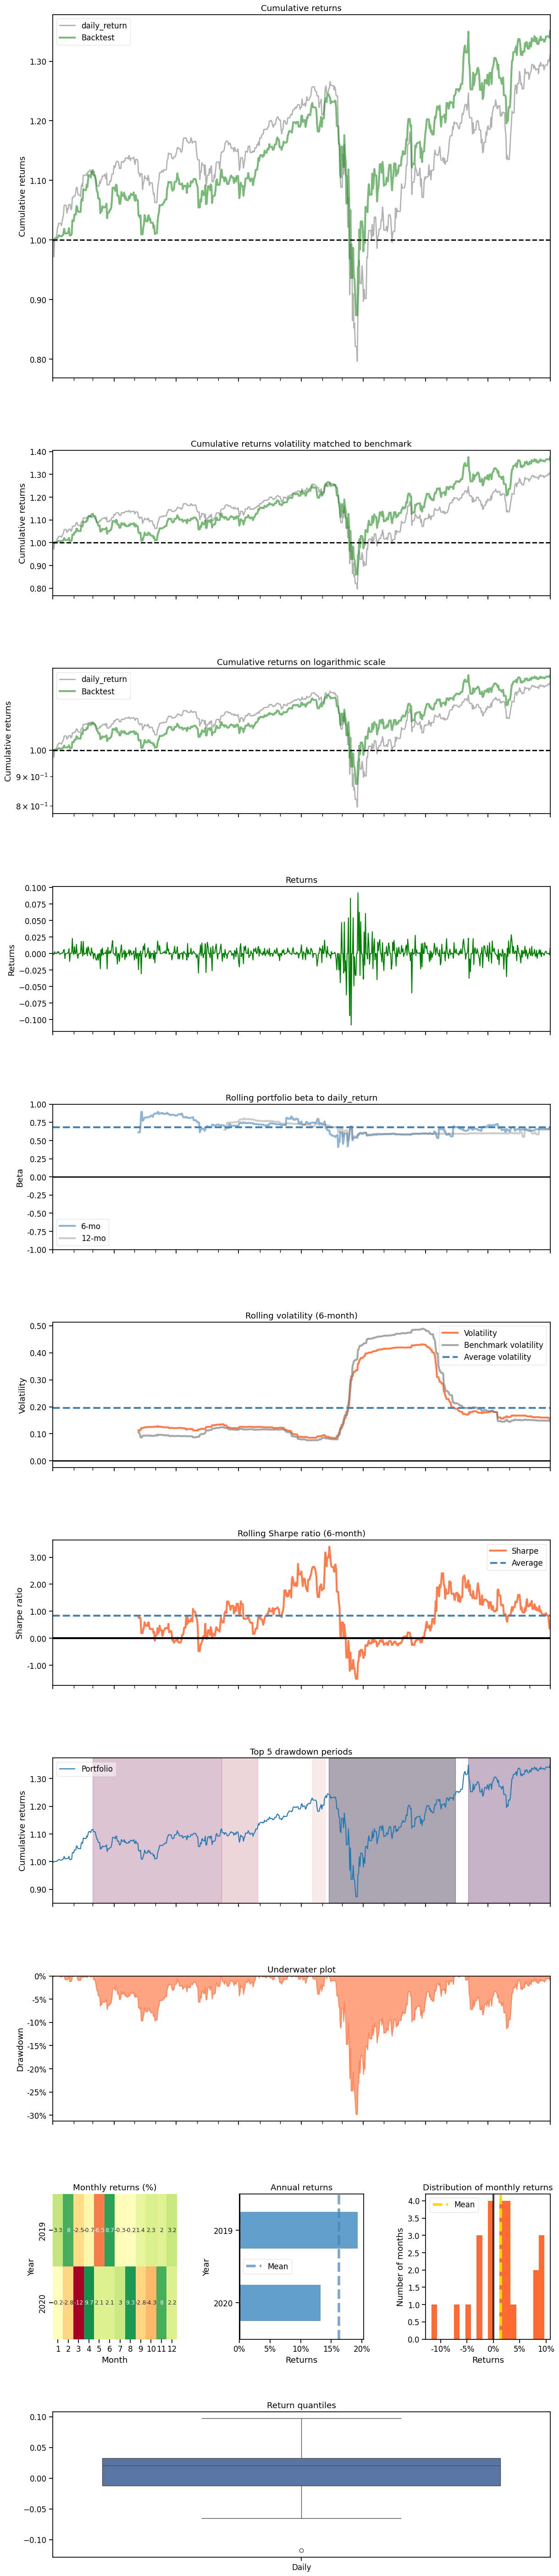

In [222]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(df_account_value_ppo, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

# backtest_plot(df_account_value_ddpg, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

# backtest_plot(df_account_value_sac, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

# if if_using_td3:
#   backtest_plot(df_account_value_td3, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

# if if_using_a2c:
#   backtest_plot(df_account_value_a2c, 
#               baseline_ticker = '^DJI', 
#               baseline_start = TEST_START_DATE,
#               baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [223]:
# print(DOW_30_TICKER)
test_portfolio = DOW_30_TICKER
len(test_portfolio)

30

In [224]:
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [225]:
df_stock_test_ = get_baseline(
        ticker='AXP', 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
df_stock_test_

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)


,date,open,high,low,close,volume,tic,day
0,2019-01-02,93.910004,96.269997,93.769997,88.798752,4175400,AXP,2
1,2019-01-03,94.790001,95.180000,93.230003,87.065483,4776600,AXP,3
2,2019-01-04,95.370003,98.349998,94.900002,90.988678,4637200,AXP,4
3,2019-01-07,97.769997,98.919998,97.019997,91.482590,3289000,AXP,0
4,2019-01-08,98.690002,99.519997,97.519997,91.929893,3227200,AXP,1
...,...,...,...,...,...,...,...,...
500,2020-12-24,116.930000,117.440002,115.820000,112.480164,707000,AXP,3
501,2020-12-28,118.050003,119.349998,117.599998,113.448257,1878700,AXP,0
502,2020-12-29,119.239998,119.349998,118.000000,113.237389,1860400,AXP,1
503,2020-12-30,118.250000,119.949997,118.150002,114.473862,1954200,AXP,2


In [226]:
for field in modify_fields:
    df_stock_test_[field] = df_stock_test_[field]/df_stock_test_.iloc[0][field]/len(test_portfolio)
df_stock_test_ = df_stock_test_[used_columns]

In [227]:
df_stock_test_

,date,close
0,2019-01-02,0.033333
1,2019-01-03,0.032683
2,2019-01-04,0.034155
3,2019-01-07,0.034341
4,2019-01-08,0.034509
...,...,...
500,2020-12-24,0.042223
501,2020-12-28,0.042586
502,2020-12-29,0.042507
503,2020-12-30,0.042971


In [228]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = df_stock_test_.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = df_stock_test_.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    for field in modify_fields:
        df_stock_[field] = df_stock_[field]/df_stock_.iloc[0][field]/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_test_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


==============Get Baseline Stats===========
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (505, 8)
Shape of DataFrame:  (452, 8)
Annual return          0.142114
Cumulative returns     0.305113
Annual volatility      0.469803
Sharpe ratio           0.512251
Calmar ratio           0.286299
Stability              0.056139
Max drawdown          -0.496385
Omega ratio            1.119716
Sortino ratio          0.809098
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.872313
Daily value at risk   -0.058235
dtype: float64


In [229]:
df_hold_

,date,close
0,2019-01-02,1.000000
1,2019-01-03,0.980481
2,2019-01-04,1.024662
3,2019-01-07,1.030224
4,2019-01-08,1.035261
...,...,...
500,2020-12-24,1.266686
501,2020-12-28,1.277588
502,2020-12-29,1.275214
503,2020-12-30,1.289138


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [230]:
df_hold_.date = pd.to_datetime(df_hold_['date'])
df_hold_ = pd.merge(df_account_value_ppo['date'],df_hold_,how='left')
df_hold_.bfill(inplace=True)
df_hold_

,date,close
0,2019-01-01,1.000000
1,2019-01-02,1.000000
2,2019-01-03,0.980481
3,2019-01-04,1.024662
4,2019-01-05,1.030224
...,...,...
726,2020-12-27,1.277588
727,2020-12-28,1.277588
728,2020-12-29,1.275214
729,2020-12-30,1.289138


In [231]:
df_hold = pd.DataFrame()
df_hold['date'] = df_account_value_ppo['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2019-01-01  1.000000e+06
2019-01-02  1.000000e+06
2019-01-03  9.804809e+05
2019-01-04  1.024662e+06
2019-01-05  1.030224e+06
...                  ...
2020-12-27  1.277588e+06
2020-12-28  1.277588e+06
2020-12-29  1.275214e+06
2020-12-30  1.289138e+06
2020-12-31  1.305113e+06

[731 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2019-01-01  1.000000e+06  1.000000e+06
2019-01-02  9.999785e+05  1.000000e+06
2019-01-03  9.984766e+05  9.804809e+05
2019-01-04  1.001223e+06  1.024662e+06
2019-01-05  1.001393e+06  1.030224e+06
...                  ...           ...
2020-12-27  1.341681e+06  1.277588e+06
2020-12-28  1.341680e+06  1.277588e+06
2020-12-29  1.341934e+06  1.275214e+06
2020-12-30  1.339327e+06  1.289138e+06
2020-12-31  1.350594e+06  1.305113e+06

[731 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

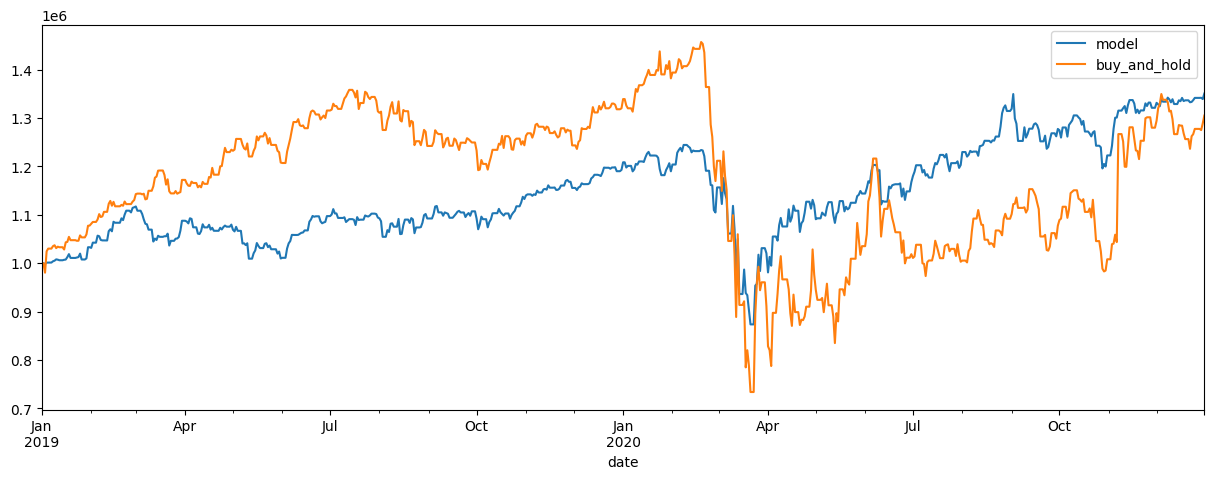

In [232]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();